In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from alibi.explainers import Counterfactual
import shap

In [3]:
tf.compat.v1.reset_default_graph()

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')
df = df.drop(['dteday', 'registered', 'casual'], axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,temp,atemp,hum,windspeed,cnt,workday,weather,days_since_2011,cnt_2d_bfr
0,3,WINTER,2011,JAN,N,MON,1.229108,22.439770,43.7273,16.636703,1349,Y,GOOD,2,985
1,4,WINTER,2011,JAN,N,TUE,1.400000,23.212148,59.0435,10.739832,1562,Y,GOOD,3,801
2,5,WINTER,2011,JAN,N,WED,2.666979,23.795180,43.6957,12.522300,1600,Y,GOOD,4,1349
3,6,WINTER,2011,JAN,N,THU,1.604356,23.929106,51.8261,6.000868,1606,Y,GOOD,5,1562
4,7,WINTER,2011,JAN,N,FRI,1.236534,23.100526,49.8696,11.304642,1510,Y,MISTY,6,1600


In [6]:
features = df.drop('cnt_2d_bfr', axis=1)
target = df['cnt_2d_bfr']
features.shape, target.shape

((728, 14), (728,))

In [10]:
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workday', 'weather']

categorical_columns_indices = [features.columns.tolist().index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [features.columns.tolist().index(cn) for cn in features.columns.tolist() if cn not in categorical_columns_names]

In [11]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_columns_indices),
                                  ('cat', OneHotEncoder(), categorical_columns_indices)])

In [14]:
X = preprocessor.fit_transform(features)
y = target.copy()
X.shape

(728, 39)

In [34]:
transformed_feature_names = preprocessor.get_feature_names_out()
X = pd.DataFrame(X, columns=transformed_feature_names)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((582, 39), (146, 39), (582,), (146,))

In [36]:
model = XGBRegressor(n_estimators=100, eta=0.3, max_depth=3, objective='count:poisson', random_state=0)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9239930510520935, 0.8369861841201782)

In [40]:
explainer = shap.Explainer(model)
explanation = explainer(X_test, check_additivity=False)
explanation

.values =
array([[ 3.19992065e-01,  6.40947223e-02, -7.01945275e-03, ...,
         0.00000000e+00, -1.24451043e-02,  7.98289024e-04],
       [ 2.30299130e-01,  6.30848333e-02, -1.44670475e-02, ...,
         0.00000000e+00, -1.21872108e-02, -5.73694007e-04],
       [ 3.02988917e-01,  6.89290166e-02, -9.50954296e-03, ...,
         0.00000000e+00, -6.00135233e-03, -2.39030400e-04],
       ...,
       [-7.12102652e-02, -1.86579116e-02, -4.10869457e-02, ...,
         0.00000000e+00,  4.66913432e-02,  1.27942709e-03],
       [-5.38138688e-01,  5.83604239e-02, -2.10239440e-02, ...,
         0.00000000e+00,  4.95250821e-02,  4.70770698e-04],
       [ 3.24458629e-01,  7.36002624e-02, -1.11424886e-02, ...,
         0.00000000e+00, -1.02084810e-02, -5.73694007e-04]], dtype=float32)

.base_values =
array([8.407964, 8.407964, 8.407964, 8.407964, 8.407964, 8.407964,
       8.407964, 8.407964, 8.407964, 8.407964, 8.407964, 8.407964,
       8.407964, 8.407964, 8.407964, 8.407964, 8.407964, 8.407964,
 

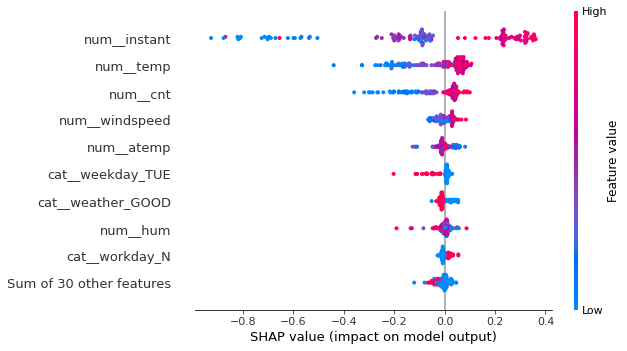

In [38]:
shap.plots.beeswarm(explanation)

In [42]:
if isinstance(explanation.values, list) or len(explanation.values.shape) == 3:
    class_index_to_explain = 1
    shap_values_2d = explanation.values[:, :, class_index_to_explain]
    print(f"분류 문제: {class_index_to_explain}번 클래스에 대한 중요도를 계산합니다.")
else:
    # 회귀 문제일 경우
    shap_values_2d = explanation.values
    print("회귀 문제: 피처 중요도를 계산합니다.")

feature_names = X_test.columns

mean_abs_shap = np.abs(shap_values_2d).mean(axis=0)

feature_importance_df = pd.DataFrame({'feature':feature_names, 'importance':mean_abs_shap})

feature_importance_df

회귀 문제: 피처 중요도를 계산합니다.


,feature,importance
0,num__instant,0.275417
1,num__temp,0.094955
2,num__atemp,0.022295
3,num__hum,0.015701
4,num__windspeed,0.023152
5,num__cnt,0.077643
6,num__days_since_2011,0.000000
7,cat__season_FALL,0.000000
8,cat__season_SPRING,0.001695
9,cat__season_SUMMER,0.000765


In [45]:
top_n = 9
top_features = feature_importance_df['feature'].head(top_n).tolist()
top_features

['num__instant',
 'num__temp',
 'num__atemp',
 'num__hum',
 'num__windspeed',
 'num__cnt',
 'num__days_since_2011',
 'cat__season_FALL',
 'cat__season_SPRING']

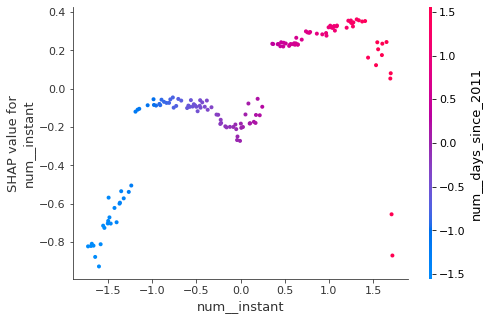

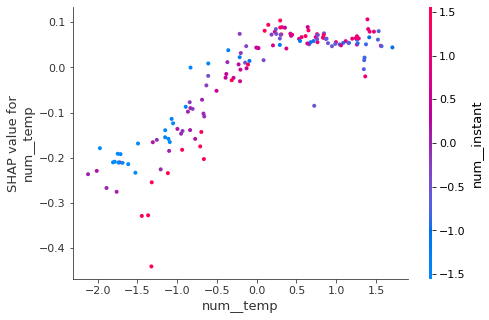

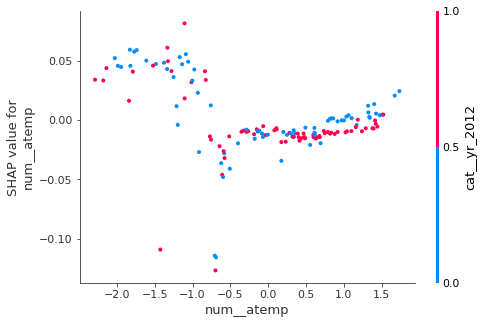

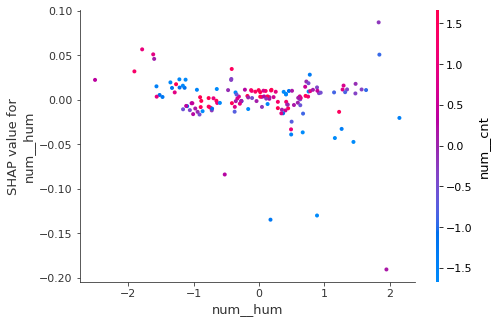

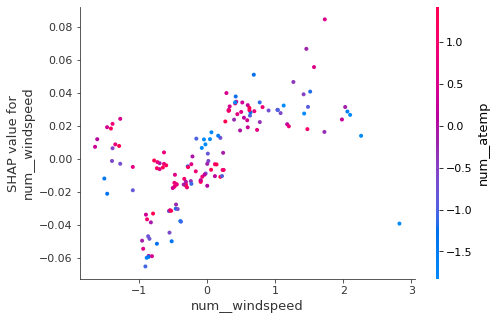

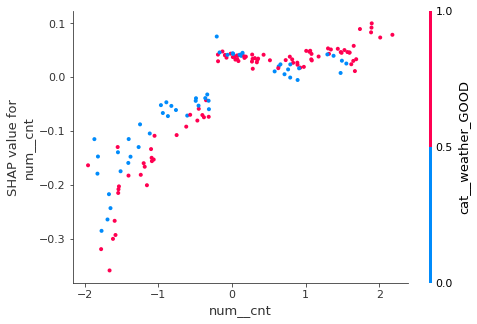

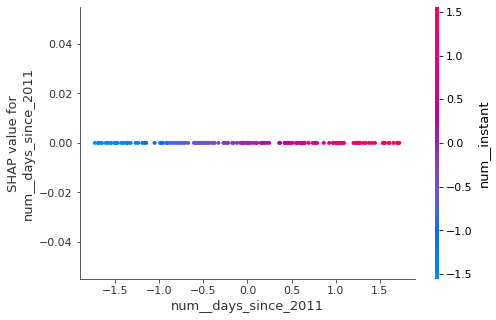

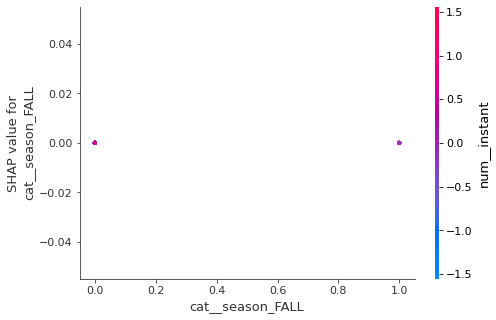

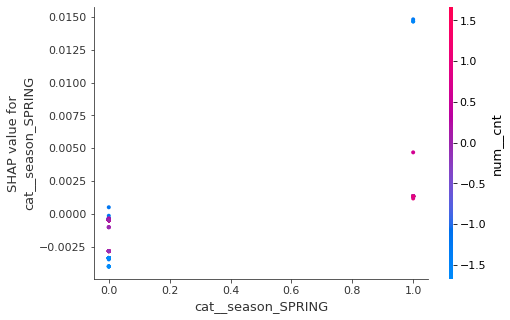

In [46]:
for name in top_features:
    shap.dependence_plot(ind=name, shap_values=explanation.values, features=X_test, interaction_index='auto')